# Investigate Dimensionality Reduction Techniques for comparing Vision Models
This notebook introduces dimensionality reduction on the last-layer activations of our CIFAR10 models. It is possible to either perform t-SNE or PCA. However, other methods can be added easily.

In [1]:
# imports
import os
import random
import torch
import numpy as np

import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from data_utils.data_stats import MEAN_DICT, STD_DICT, CLASS_DICT
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import timm

In [2]:
# Dataset Configuration
from models.networks import get_model
from models.resnet import resnet18
dataset_name = 'cifar10'
mean = MEAN_DICT[dataset_name]
std = STD_DICT[dataset_name]
num_classes = CLASS_DICT[dataset_name]
dataset_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]
device = "cpu"

dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

assert len(dataset_classes) == num_classes

Files already downloaded and verified


In [3]:
# Setup dataloader
data_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=512,
                                          shuffle=True,
                                          num_workers=2)

Select the architecture by executing the corresponding cell and follow the comments below.

In [67]:
# ResNet Configuration
model = resnet18(pretrained=True)
model_transform = transforms.Compose([
    transforms.Normalize(mean / 255., std / 255.)
])

In [34]:
# MLP Configuration
mlp_architecture = 'B_12-Wi_512'  # B_12-Wi_512
mlp_resolution = 64  # Resolution of fine-tuned model (64 for all models we provide)
if not os.path.exists("checkpoints"):
    os.mkdir("checkpoints")
mlp_checkpoint = 'in21k_cifar10'  # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10
model = get_model(architecture=mlp_architecture, resolution=mlp_resolution, num_classes=num_classes,
                  checkpoint=mlp_checkpoint)
model_transform = transforms.Compose([
    transforms.transforms.Resize((mlp_resolution, mlp_resolution)),
    transforms.Normalize(mean / 255., std / 255.)
])

Weights already downloaded
Load_state output <All keys matched successfully>


In [4]:
# ViT Configuration
vit_checkpoint = "./models/ViT_CIFAR10.py"  # B_12-Wi_512
vit_resolution = 384
checkpoint = torch.load(vit_checkpoint, map_location=torch.device(device))
model = timm.create_model("vit_base_patch16_384", pretrained=True)
model.head = torch.nn.Linear(model.head.in_features, num_classes)
model = torch.nn.DataParallel(model) # make parallel
model.load_state_dict(checkpoint['model'])
model_transform = transforms.Compose([
    transforms.Resize(vit_resolution),
    transforms.Normalize(mean / 255., std / 255.)
])

In [5]:
# get random image
def get_random_image():
    image_nr = random.randrange(len(dataset))  # random image
    # image_nr = 9297  # specific image id

    image, true_label = dataset[image_nr]

    image_np = image.numpy().transpose((1, 2, 0))
    plt.imshow(image_np)
    plt.show()

    print(f"Picked image {image_nr} with true label '{dataset_classes[true_label]}'.")

    return image, true_label

# reshape to get input tensor for a particular image
def get_input_tensor(img):
    img = model_transform(img).unsqueeze(0)
    # img = torch.reshape(img, (img.shape[0], -1)) # enable with MLP
    return img

In [14]:
amount_points = 500  # how many points we want in our plot

#########################

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# model.layer4.register_forward_hook(get_activation('layer_activations'))  # for ResNet18
# model.blocks[11].register_forward_hook(get_activation('layer_activations'))  # for MLP
model.module.fc_norm.register_forward_hook(get_activation('layer_activations'))  # for ViT
model.eval()

intermediate_values: list[torch.Tensor] = []
predicted_classes: list[int] = []
true_classes: list[int] = []

with torch.no_grad():
    for _ in range(amount_points):
        image_nr = random.randrange(len(dataset))  # random image

        image, true_label = dataset[image_nr]
        output = model(get_input_tensor(image))
        
        probabilities = torch.nn.functional.softmax(output, dim=-1).squeeze()
        predicted_class = torch.argmax(probabilities).item()
        
        intermediate_values.append(activation['layer_activations'].flatten())
        predicted_classes.append(predicted_class)
        true_classes.append(true_label)
intermediate_values = torch.stack(intermediate_values)
predicted_classes = np.array(predicted_classes, dtype=np.int32)
true_classes = np.array(true_classes, dtype=np.int32)

print(f"Intermediate values have shape: {intermediate_values.shape}")

Intermediate values have shape: torch.Size([500, 768])


Text(0.5, 1.0, 'TSNE of dataset cifar10 for ViT')

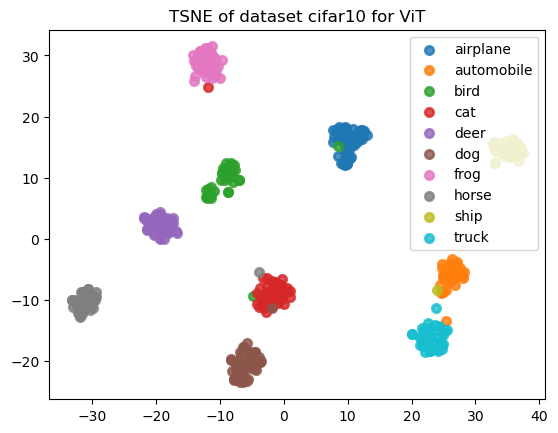

In [15]:
# apply dimensionality reduction
method_name = "PCA"  # PCA or TSNE

#########################

if not (method_name == "PCA" or method_name == "TSNE"):
    print(f"Method {method_name} not found! Set to default value (PCA)")
    method_name = "PCA"
else:
    if method_name == "PCA":
        method = PCA(n_components=2)
    elif method_name == "TSNE":
        method = TSNE(n_components=2, random_state=0)

X = method.fit_transform(intermediate_values)

# Percentage of variance explained for each components (only for PCA)
print(f"Explained variance ratio (first two components): {str(method.explained_variance_ratio_)}")

plt.figure()
lw = 2

for idx in range(10):
    plt.scatter(
        X[true_classes == idx, 0], X[true_classes == idx, 1], alpha=0.8, lw=lw, label=dataset_classes[idx]
    )
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title(f"{method_name} of dataset {dataset_name} for ViT")